In [1]:
from google.colab import drive
drive.mount('/root/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /root/drive


In [2]:
%cd
%cd /root/drive/My Drive/aspect_based_sa
!ls

/root
/root/drive/My Drive/aspect_based_sa
accuracy.png  data_restaurant  mmd_2019.ipynb		    stopwords
aspect.ipynb  embedding        mmd_2019_new_approach.ipynb  vncorenlp
clean_data    f1.png	       model_plot.png
data_hotel    loss.png	       report


In [0]:
#@title PREPARE_DATA
import numpy as np
import pandas as pd
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
import re

def prepare_data(d_train, d_dev, d_test):
  d_train['Review'] = d_train['Review'].apply(lambda x: re.findall(r'\S+', str(x)))
  d_dev['Review'] = d_dev['Review'].apply(lambda x: re.findall(r'\S+', str(x)))
  d_test['Review'] = d_test['Review'].apply(lambda x: re.findall(r'\S+', str(x)))

  X_train = d_train.Review
  X_dev = d_dev.Review
  X_test = d_test.Review

  columns = list(d_train.iloc[:,5:].columns)

  y_train = d_train[columns].values
  y_test = d_test[columns].values
  y_dev = d_dev[columns].values

  y_train = np.array([np.reshape(item, (len(columns),)) for item in y_train])
  y_dev = np.array([np.reshape(item, (len(columns),)) for item in y_dev])
  y_test = np.array([np.reshape(item, (len(columns),)) for item in y_test])

  merge_list = np.concatenate([np.array(X_train), np.array(X_dev)])

  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(merge_list)

  X_train = tokenizer.texts_to_sequences(X_train)
  X_dev = tokenizer.texts_to_sequences(X_dev)
  X_test = tokenizer.texts_to_sequences(X_test)

  return X_train, X_dev, X_test, y_train, y_dev, y_test,  tokenizer

In [0]:
#@title PAD_SEQUENCES
def pad_sequences_data(maxlen, tokenizer, X_train, X_dev, X_test):
  word_index = tokenizer.word_index
  vocab_size = len(word_index) + 1 

  X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
  X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)
  X_dev = pad_sequences(X_dev, padding='post', maxlen=maxlen)

  return X_train,X_dev, X_test, word_index, vocab_size

In [0]:
#@title GET_EMBEDDING_MODEL
import numpy as np

def get_embedding(word_index, embedding_model, embedding_dim = 300):
  error = []
  embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
  for word, i in word_index.items():
      try:
        embedding_vector = embedding_model[word]
        if embedding_vector is not None:
          # words not found in embedding index will be all-zeros.
          embedding_matrix[i] = embedding_vector
      except:
        error.append(word)
        pass
  return embedding_matrix, error

In [0]:
#@title F1_EVALUATION_FUNCTION
from tensorflow.keras import backend as K

def f1(y_true, y_pred):
    def recall(y_true, y_pred):

        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):

        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [0]:
#@title GET_MODEL
from keras.preprocessing import sequence
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding, Input
from keras.layers import LSTM, Bidirectional
from keras.layers import Conv1D, MaxPooling1D
from keras.optimizers import Adam

def get_model(max_feature, max_output_length, embedding_matrix, vocab_size, embedding_dim = 300):

  sequence_input = Input(shape=(max_feature,), dtype='int32')

  embedding_layer = Embedding(vocab_size,
                              embedding_dim,
                              weights=[embedding_matrix],
                              input_length=max_feature,
                              trainable=False)

  embedded_sequences = embedding_layer(sequence_input)
  conv1 =  Conv1D(256, 3, activation='relu',padding='same')(embedded_sequences)
  conv1 = MaxPooling1D()(conv1)
  conv1 = Dropout(0.5)(conv1)


  conv2 =  Conv1D(128, 3, activation='relu',padding='same')(conv1)
  conv2 = MaxPooling1D()(conv2)
  conv2 = Dropout(0.5)(conv2)

  lstm1 = Bidirectional(LSTM(128, return_sequences=True))(conv2)
  lstm2 = Bidirectional(LSTM(64))(lstm1)

  x = Dense(64, activation='relu')(lstm2)

  output = Dense(max_output_length, activation='tanh')(x)

  model = Model(sequence_input, output)
  model.compile(loss='mse',
                optimizer=Adam(lr=0.0001),
                metrics=[f1])
  return model


In [0]:
#@title OUTPUT_ACTIVATION_FUNCTION
def vinh_activation(result):
  x = result
  if(x < 0 and x < -0.5):
    return -1
  if(x < 0 and x >= -0.5):
    return -0.5
  if(x > 0 and x > 0.5):
    return 1
  if(x > 0 and x <= 0.5):
    return 0.5
  return x


In [0]:
def average_len(l):
  return sum(map(len, l))/float(len(l))

In [0]:
import glob
global files_restaurant
global files_hotel
files_restaurant = glob.glob("data_restaurant/*.csv")
files_hotel = glob.glob("data_hotel/*.csv")

In [0]:
from gensim.models.wrappers import FastText
embedding_model = FastText.load_fasttext_format('embedding/cc.vi.300.bin')

In [15]:
files_restaurant

['data_restaurant/2-VLSP2018-SA-Restaurant-dev (7-3-2018).csv',
 'data_restaurant/1-VLSP2018-SA-Restaurant-train (7-3-2018).csv',
 'data_restaurant/3-VLSP2018-SA-Restaurant-test (8-3-2018).csv']

In [0]:
import pandas as pd
d_dev_restaurant = pd.read_csv(files_restaurant[0])
d_train_restaurant = pd.read_csv(files_restaurant[1])
d_test_restaurant = pd.read_csv(files_restaurant[2])

In [0]:
X_train_restaurant, X_dev_restaurant, X_test_restaurant, y_train_restaurant, y_dev_restaurant, y_test_restaurant, tokenizer_restaurant = prepare_data(d_train_restaurant, d_dev_restaurant, d_test_restaurant)

In [42]:
print(str.format('train: {}\ndev: {}\ntest:{}',average_len(X_train_restaurant), average_len(X_dev_restaurant), average_len(X_test_restaurant)))

train: 25.60385005065856
dev: 23.211627906976744
test:73.84


In [0]:
X_train_restaurant, X_dev_restaurant, X_test_restaurant,  word_index_restaurant, vocab_size_restaurant = pad_sequences_data(30, tokenizer_restaurant, X_train_restaurant, X_dev_restaurant, X_test_restaurant)

In [0]:
embedding_matrix_restaurant, error_restaurant = get_embedding(word_index_restaurant, embedding_model)

In [45]:
# Check % words with embeddings 
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix_restaurant, axis=1))
print(nonzero_elements / vocab_size_restaurant)   

0.9679236606116348


In [0]:
restaurant_model = get_model(len(X_train_restaurant[0]), len(y_train_restaurant[0]), embedding_matrix_restaurant, vocab_size_restaurant)

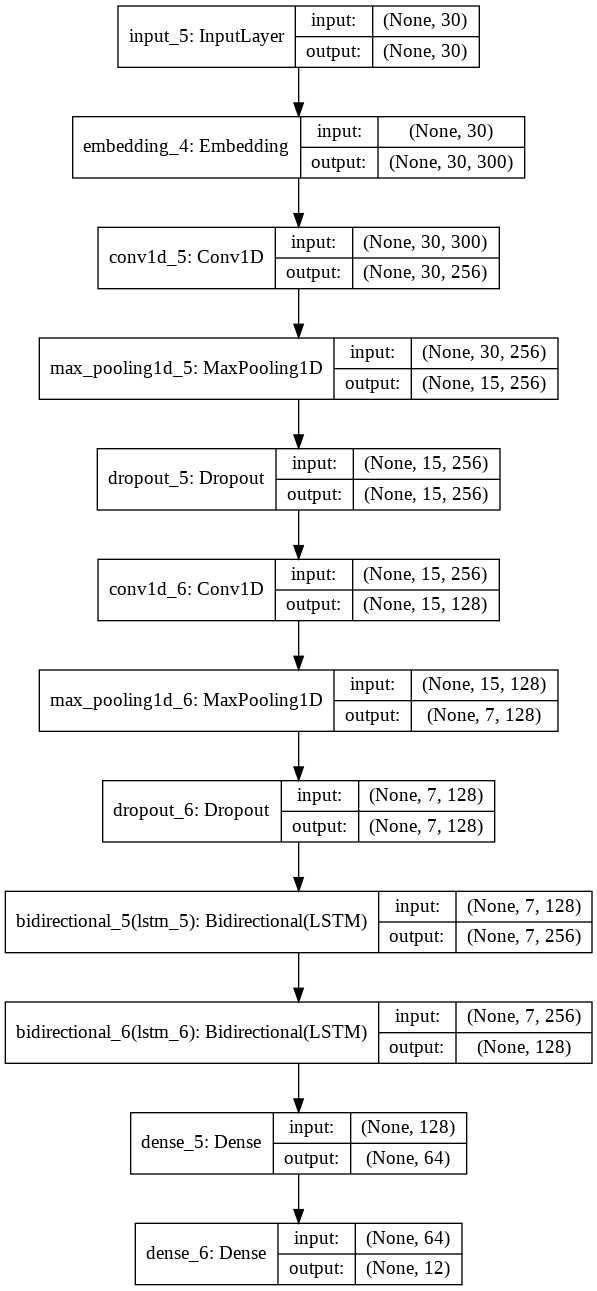

In [52]:
from keras.utils.vis_utils import plot_model
plot_model(restaurant_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [53]:
batch_size = 50
epochs = 200
cnn_lstm_restaurant = restaurant_model.fit(X_train_restaurant, y_train_restaurant,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_dev_restaurant, y_dev_restaurant))

Train on 2961 samples, validate on 1290 samples
Epoch 1/200
2961/2961 [==============================] - 9s 3ms/step - loss: 0.3173 - f1: 0.2188 - val_loss: 0.2396 - val_f1: 0.5173
Epoch 2/200
2961/2961 [==============================] - 4s 1ms/step - loss: 0.2556 - f1: 0.4947 - val_loss: 0.2217 - val_f1: 0.5594
Epoch 3/200
2961/2961 [==============================] - 5s 2ms/step - loss: 0.2466 - f1: 0.5170 - val_loss: 0.2185 - val_f1: 0.5782
Epoch 4/200
2961/2961 [==============================] - 5s 2ms/step - loss: 0.2437 - f1: 0.5444 - val_loss: 0.2175 - val_f1: 0.5879
Epoch 5/200
2961/2961 [==============================] - 5s 2ms/step - loss: 0.2419 - f1: 0.5483 - val_loss: 0.2146 - val_f1: 0.5883
Epoch 6/200
2961/2961 [==============================] - 5s 2ms/step - loss: 0.2400 - f1: 0.5447 - val_loss: 0.2157 - val_f1: 0.5924
Epoch 7/200
2961/2961 [==============================] - 5s 2ms/step - loss: 0.2369 - f1: 0.5586 - val_loss: 0.2101 - val_f1: 0.5922
Epoch 8/200
2961/2961

In [0]:
from keras.models import load_model
cnn_lstm_restaurant.model.save('domain_restaurant.h5')

In [0]:
#@title HOTEL_DOMAIN

In [56]:
files_hotel

['data_hotel/3-VLSP2018-SA-Hotel-test (8-3-2018).csv',
 'data_hotel/1-VLSP2018-SA-Hotel-train (7-3-2018).csv',
 'data_hotel/2-VLSP2018-SA-Hotel-dev (7-3-2018).csv']

In [0]:
d_test_hotel = pd.read_csv(files_hotel[0])
d_train_hotel = pd.read_csv(files_hotel[1])
d_dev_hotel = pd.read_csv(files_hotel[2])

In [0]:
X_train_hotel, X_dev_hotel, X_test_hotel, y_train_hotel, y_dev_hotel, y_test_hotel, tokenizer_hotel = prepare_data(d_train_hotel, d_dev_hotel, d_test_hotel)

In [64]:
print(str.format('train: {}\ndev: {}\ntest:{}',average_len(X_train_hotel), average_len(X_dev_hotel), average_len(X_test_hotel)))

train: 23.327666666666666
dev: 12.8645
test:15.363333333333333


In [0]:
X_train_hotel, X_dev_hotel, X_test_hotel, word_index_hotel, vocab_size_hotel = pad_sequences_data(30, tokenizer_hotel, X_train_hotel, X_dev_hotel, X_test_hotel)

In [0]:
embedding_matrix_hotel, error_hotel = get_embedding(word_index_hotel, embedding_model)

In [67]:
# Check % words with embeddings 
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix_hotel, axis=1))
print(nonzero_elements / vocab_size_hotel)   

0.9878524295140971


In [0]:
hotel_model = get_model(len(X_train_hotel[0]), len(y_train_hotel[0]), embedding_matrix_hotel, vocab_size_hotel)

In [70]:
batch_size = 50
epochs = 200
cnn_lstm_hotel = hotel_model.fit(X_train_hotel, y_train_hotel,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_dev_hotel, y_dev_hotel))

Train on 3000 samples, validate on 2000 samples
Epoch 1/200
3000/3000 [==============================] - 10s 3ms/step - loss: 0.2891 - f1: 0.0251 - val_loss: 0.2177 - val_f1: 0.0528
Epoch 2/200
3000/3000 [==============================] - 4s 1ms/step - loss: 0.2072 - f1: 0.0583 - val_loss: 0.1644 - val_f1: 0.0762
Epoch 3/200
3000/3000 [==============================] - 5s 2ms/step - loss: 0.1913 - f1: 0.0600 - val_loss: 0.1571 - val_f1: 0.0378
Epoch 4/200
3000/3000 [==============================] - 4s 1ms/step - loss: 0.1889 - f1: 0.0557 - val_loss: 0.1530 - val_f1: 0.0646
Epoch 5/200
3000/3000 [==============================] - 5s 2ms/step - loss: 0.1882 - f1: 0.0493 - val_loss: 0.1518 - val_f1: 0.0611
Epoch 6/200
3000/3000 [==============================] - 5s 2ms/step - loss: 0.1878 - f1: 0.0457 - val_loss: 0.1529 - val_f1: 0.0558
Epoch 7/200
3000/3000 [==============================] - 4s 1ms/step - loss: 0.1873 - f1: 0.0480 - val_loss: 0.1509 - val_f1: 0.0607
Epoch 8/200
3000/300

In [0]:
from keras.models import load_model
cnn_lstm_hotel.model.save('domain_hotel.h5')

In [74]:
cnn_lstm_hotel.model.evaluate(X_test_hotel, y_test_hotel)

600/600 [==============================] - 0s 435us/step


[0.13132367501656214, 0.7943965943654379]

In [0]:
#@title EVALUATION

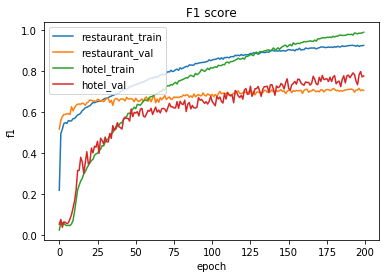

In [80]:
import keras
from matplotlib import pyplot as plt
plt.plot(cnn_lstm_restaurant.history['f1'])
plt.plot(cnn_lstm_restaurant.history['val_f1'])

plt.plot(cnn_lstm_hotel.history['f1'])
plt.plot(cnn_lstm_hotel.history['val_f1'])

plt.title('F1 score')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['restaurant_train', 'restaurant_val','hotel_train', 'hotel_val'], loc='upper left')
plt.show()

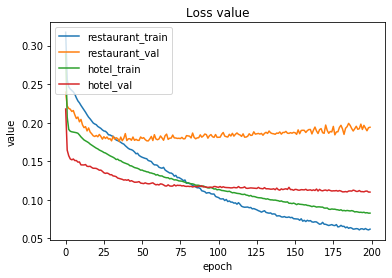

In [78]:
import keras
from matplotlib import pyplot as plt
plt.plot(cnn_lstm_restaurant.history['loss'])
plt.plot(cnn_lstm_restaurant.history['val_loss'])

plt.plot(cnn_lstm_hotel.history['loss'])
plt.plot(cnn_lstm_hotel.history['val_loss'])

plt.title('Loss value')
plt.ylabel('value')
plt.xlabel('epoch')
plt.legend(['restaurant_train', 'restaurant_val','hotel_train', 'hotel_val'], loc='upper left')
plt.show()

In [0]:
#@title TESTING

In [0]:
y_pred_restaurant = cnn_lstm_restaurant.model.predict(X_test_restaurant[0:10])

In [0]:
y_pred_restaurant = [[vinh_activation(item) for item in items]for items in y_pred_restaurant]

In [108]:
np.array(y_pred_restaurant[9])

array([-1. ,  1. , -0.5,  0.5, -1. , -0.5, -0.5, -1. , -1. ,  0.5,  0.5,
       -0.5])

In [107]:
y_test_restaurant[0:10][9]

array([ 1. ,  1. ,  0.5, -0.5, -0.5, -0.5,  1. , -1. ,  0.5, -0.5, -0.5,
        1. ])